# 1. Gaussian Mixture Model

Exploration of the IoT dataset

## 1. Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
filepath = '../Pandas_ML_Project_SNR_Minus5.csv' # go up one folder

data = pd.read_csv(filepath, delimiter=',', usecols=range(1, 13))
data.info()
data.head()

FileNotFoundError: [Errno 2] No such file or directory: '../Pandas_ML_Project_SNR_Minus5.csv'

## 2. Exploratory

In [56]:
import seaborn as sns
import random

<AxesSubplot:>

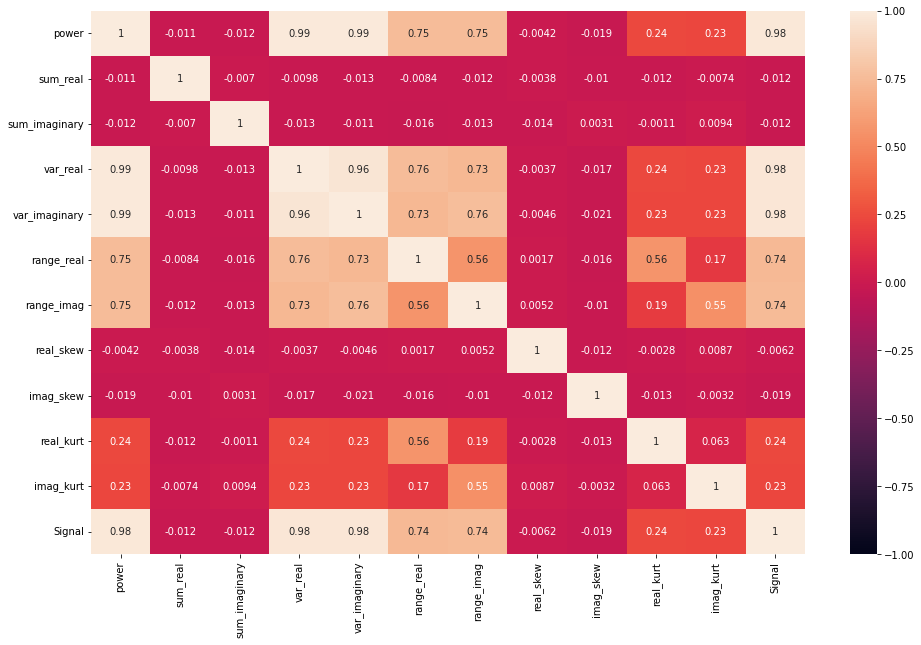

In [21]:
plt.figure(figsize=(16,10))
sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True)

As we can see above: power, var_real, var_imaginary, range_real, range_imag are the most correlated columns to the target column (signal). We might keep this in mind to select on which features to train our model

<AxesSubplot:xlabel='power', ylabel='Count'>

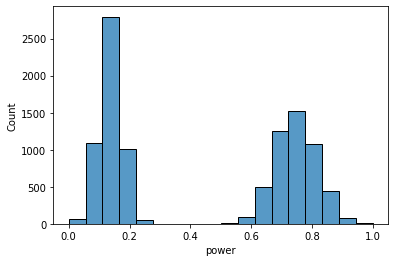

In [23]:
sns.histplot(data.power)

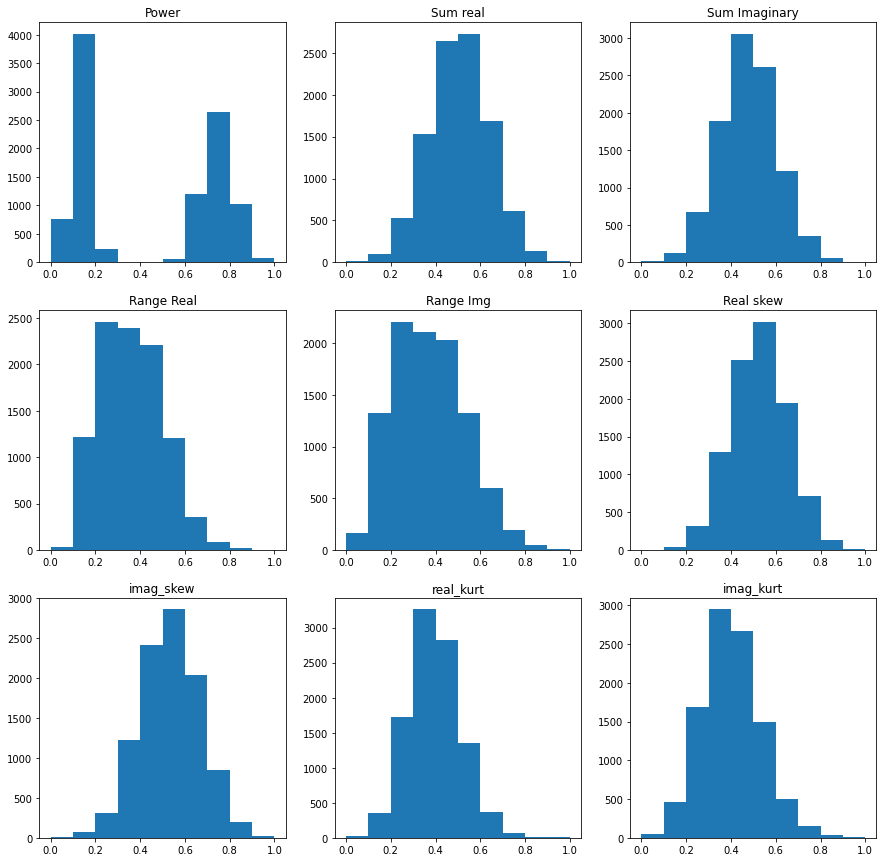

In [40]:
plt.figure(figsize=(15,15))
plt.subplot(3,3,1)
plt.title("Power")
plt.hist(data.power)

plt.subplot(3,3,2)
plt.title("Sum real")
plt.hist(data.sum_real)

plt.subplot(3,3,3)
plt.title("Sum Imaginary")
plt.hist(data.sum_imaginary)

plt.subplot(3,3,4)
plt.title("Range Real")
plt.hist(data.range_real)

plt.subplot(3,3,5)
plt.title("Range Img")
plt.hist(data.range_imag)

plt.subplot(3,3,6)
plt.title("Real skew")
plt.hist(data.real_skew)

plt.subplot(3,3,7)
plt.title("imag_skew")
plt.hist(data.imag_skew)

plt.subplot(3,3,8)
plt.title("real_kurt")
plt.hist(data.real_kurt)

plt.subplot(3,3,9)
plt.title("imag_kurt")
plt.hist(data.imag_kurt)

plt.show()

All features have a normal distribution, with the exception of power

## 3. Modelling with GMM

In [64]:
# get X and y
y_df = data.iloc[:, 11]
X_df = data.iloc[:, 0:11]

X = X_df.to_numpy()
y = y_df.to_numpy()
print(X.shape, y.shape)

(10000, 11) (10000,)


Train test split

In [62]:
def partition(X, y, percent_train):
    
    # 1. create index list
    idx = np.arange(0,y.shape[0])
#     random.seed(1412)
    
    # 2. shuffle index
    random.shuffle(idx)
    
    # 3. Create train/test index
    split = int(y.shape[0] * percent_train)
    train_idx = idx[:split]
    test_idx = idx[split:]
    
    # 4. Separate X_Train, y_train, X_test, y_test
    X_train = X.iloc[train_idx, :]
    X_test =  X.iloc[test_idx, :]
    
    y_train = y.iloc[train_idx]
    y_test =  y.iloc[test_idx]
    
    # 5. Get y_labels_name from y using pandas.unique function
    y_labels_name = pd.unique(y)
    
    # 6. Change y_labels_name into string number and put into y_labels_new
    y_labels_new = np.arange(len(y_labels_name))
    
    # 7. Drop shuffle index columns
    #     - pandas.reset_index() and pandas.drop(...) might be help
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    
    for index, label in enumerate(y_labels_name):
        y_train = y_train.replace(label, y_labels_new[index])
        y_test = y_test.replace(label, y_labels_new[index])
    
    
    return idx, X_train, y_train, X_test, y_test, y_labels_name, y_labels_new

In [63]:
idx, X_train, y_train, X_test, y_test, y_labels_name, y_labels_new = partition(X_df, y_df, 0.8)
print(X_train.shape, X_test.shape, y_test.shape)

(8000, 11) (2000, 11) (2000,)


### Find the Best K using Elbow Method

Since we know there are only 2 clusters (or 2 targets), this step isn't necessary but we will run it just for the sake of it

In [66]:
df = data

def init_kmeans(X, k):
    m = X.shape[0]
    n = X.shape[1]
    means = np.zeros((k,n))
    order = np.random.permutation(m)[:k]
    for i in range(k):
        means[i,:] = X[order[i],:]
    return means

# Run one iteration of k-means

def iterate_kmeans(X, means):
    m = X.shape[0]
    n = X.shape[1]
    k = means.shape[0]
    distortion = np.zeros(m)
    c = np.zeros(m)
    for i in range(m):
        min_j = 0
        min_dist = 0
        for j in range(k):
            dist_j = np.linalg.norm(X[i,:] - means[j,:])
            if dist_j < min_dist or j == 0:
                min_dist = dist_j
                min_j = j
        distortion[i] = min_dist
        c[i] = min_j
    for j in range(k):
        means[j,:] = np.zeros((1,n))
        nj = 0
        for i in range(m):
            if c[i] == j:
                nj = nj + 1
                means[j,:] = means[j,:] + X[i,:]
        if nj > 0:
            means[j,:] = means[j,:] / nj
    return means, c, np.sum(distortion)

K= 1
K= 2
K= 3
K= 4
K= 5
K= 6
K= 7


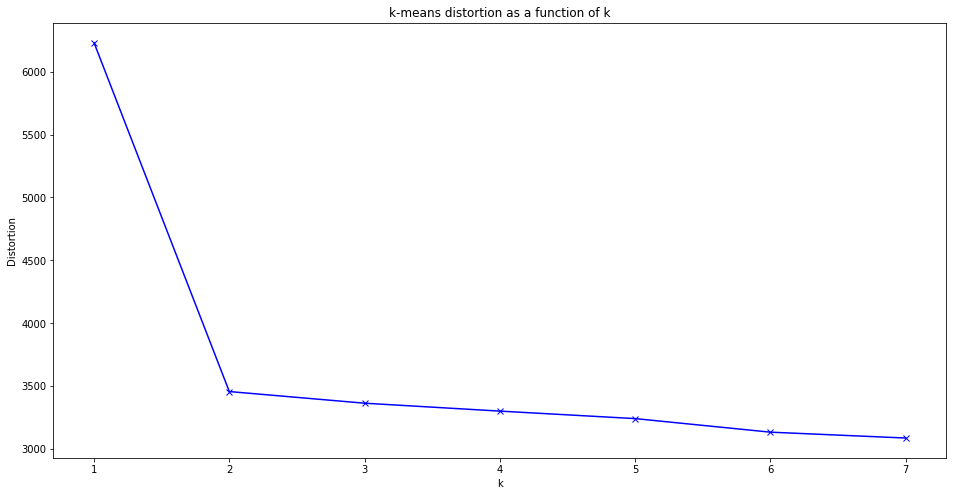

In [68]:

# Find the ideal K

max_k = 7
epsilon = 0.001
epochs = 50
batch_size = 400

# For each value of k, do one run and record the resulting cost (Euclidean distortion)

distortions = np.zeros(max_k)
for k in range(1, max_k + 1):
    print(f"K= {k}")
    ix = np.random.randint(0, X.shape[0]-400) # minibatch
    X_batch = X[ix:ix+batch_size]
    means = init_kmeans(X_batch, k)
    prev_distortion = 0
    dist_arr = []
    while True:
        for e in range(epochs):
            means, c, distortion = iterate_kmeans(X, means)
            dist_arr.append(distortion)
        distortion = dist_arr[np.argmin(dist_arr)]
        if prev_distortion > 0 and prev_distortion - distortion < epsilon:
            break
        prev_distortion = distortion
    distortions[k-1] = distortion

# Plot distortion as function of k

plt.figure(figsize=(16,8))
plt.plot(range(1,max_k+1), distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('k-means distortion as a function of k')
plt.show()

### Model

In [72]:
def init_gmm(X, k):
    m = X.shape[0]
    n = X.shape[1]
    Mu = np.zeros((n,k))
    Sigma = np.zeros((k,n,n))
    Phi = np.zeros(k)
    order = np.random.permutation(m)
    for j in range(k):
        # Initially assign equal probability to each cluster/outcome
        Phi[j] = 1/k      
        # Ramdomly assign mean to one of the data points       
        Mu[:,j] = X[order[j],:].T
        # Initial covariance is identity matrix
        Sigma[j,:,:] = np.eye(n)    
    return Phi, Mu, Sigma


def Gaussian(X, mean, covariance):
    k = len(mean)
    X = X - mean.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(covariance)**0.5)) * np.exp(-0.5 * np.sum(X @ np.linalg.pinv(covariance) * X, axis=1))
    return p

def gaussian(x, mean,covariance):
    k = len(mean)
    X = (x - mean).reshape(-1,1)
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(covariance)**0.5)) * np.exp(-0.5 * (X.T @ np.linalg.pinv(covariance) @ X))
    return p


# Run one iteration of EM

def iterate_em_gmm(X, threshold, Phi, Mu, Sigma):
    m = X.shape[0]
    n = X.shape[1]
    k = len(Phi)
    threshold = np.reshape(np.repeat(threshold, n*k), (n,k))
    pj_arr = np.zeros((m,k))
    
    # E-step: calculate w_j^i
    W = np.zeros((m, k))
    for j in range(k):
        pj = Gaussian(X, Mu[:,j], Sigma[j])
        pj_arr[:,j] = pj
        W[:,j] = Phi[j] * pj
    
    # W tells us what is the relative weight of each cluster for each data point
    W[:,:] = W * np.tile(1/np.sum(W,1),(k,1)).T

    # M-step: adjust mean and sigma
    Phi[:] = sum(W) / m
    Mu_previous = Mu.copy()
    for j in range(k):
        # Split cluster specific W for each dimension
        Wj = np.tile(W[:,j],(2,1)).T
        # Compute Mu for each variable for each cluster
        Mu[:,j] = sum(X * Wj)/sum(Wj)
        Muj = np.tile(Mu[:,j],(m,1))
        Sigma[j,:,:] = np.matmul((X - Muj).T, (X - Muj) * Wj) / sum(W[:,j])

    if (abs(Mu-Mu_previous) <= threshold).all():
        converged = True
    else:
        converged = False

    labels = np.argmax(pj_arr, axis = 1)
    pj = np.max(pj_arr,axis=1)
    X_label = np.insert(X, 2, labels, axis=1)
    return converged, pj, X_label

In [75]:
n = X.shape[1]
m = X.shape[0]
k = 2

# Slightly different version of init_gmm due to the data format and spread
def init_gmm(X, k):
    Mu = np.zeros((n,k))
    Sigma = np.zeros((k,n,n))
    Phi = np.zeros(k)
    order = np.random.permutation(m)
    for j in range(k):
        Phi[j] = 1/k
        Mu[:,j] = X[order[j],:].T
        Sigma[j,:,:] = np.cov(X.T)
    return Phi, Mu, Sigma

# def init_gmm(X, k):
#     m = X.shape[0]
#     n = X.shape[1]
#     Mu = np.zeros((n,k))
#     Sigma = np.zeros((k,n,n))
#     Phi = np.zeros(k)
#     order = np.random.permutation(m)
#     for j in range(k):
#         # Initially assign equal probability to each cluster/outcome
#         Phi[j] = 1/k      
#         # Ramdomly assign mean to one of the data points       
#         Mu[:,j] = X[order[j],:].T
#         # Initial covariance is identity matrix
#         Sigma[j,:,:] = np.eye(n)    
#     return Phi, Mu, Sigma

def iterate_em_gmm(X, threshold, Phi, Mu, Sigma):
    m = X.shape[0]
    n = X.shape[1]
    k = len(Phi)
    threshold = np.reshape(np.repeat(threshold, n*k), (n,k))
    pj_arr = np.zeros((m,k))
    
    # E-step: calculate w_j^i
    W = np.zeros((m, k))
    for j in range(k):
        pj = Gaussian(X, Mu[:,j], Sigma[j])
        pj_arr[:,j] = pj
        W[:,j] = Phi[j] * pj
    
    # W tells us what is the relative weight of each cluster for each data point
    W[:,:] = W * np.tile(1/np.sum(W,1),(k,1)).T

    # M-step: adjust mean and sigma
    Phi[:] = sum(W) / m
    Mu_previous = Mu.copy()
    for j in range(k):
        # Split cluster specific W for each dimension
        Wj = np.tile(W[:,j],(11,1)).T
        # Compute Mu for each variable for each cluster
        Mu[:,j] = sum(X * Wj)/sum(Wj)
        Muj = np.tile(Mu[:,j],(m,1))
        Sigma[j,:,:] = np.matmul((X - Muj).T, (X - Muj) * Wj) / sum(W[:,j])

    if (abs(Mu-Mu_previous) <= threshold).all():
        converged = True
    else:
        converged = False

    labels = np.argmax(pj_arr, axis = 1)
    pj = np.max(pj_arr,axis=1)
    X_label = np.insert(X, 2, labels, axis=1)
    return converged, pj, X_label

In [77]:
threshold = np.matrix(.01)

Phi, Mu, Sigma = init_gmm(X, k)

converged = False
while not converged:
    converged, pj, X_label = iterate_em_gmm(X, threshold, Phi, Mu, Sigma)


# print(Sigma, Mu, Phi)
print("done")

done


In [80]:
print(Sigma.shape)

(2, 11, 11)
